In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
%matplotlib inline

### Dados
- são carregados os dados pre-procesados no notebook: Data pre-processing

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [3]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [4]:
X_train = datos.loc[rg]
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [5]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [6]:
datos = ((datos - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
datos.shape

(4205, 9)

In [7]:
datos = datos.drop(rg)
datos.shape

(4185, 9)

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [8]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [9]:
noise_input = 50
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1359      
_________________________________________________________________
reshape (Reshape)            (None, 9)                 0         
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
_________________________________________________________________


In [11]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimensão dos dados de entrada:", noise.shape)
data_sint = G.predict(noise)
print("Dimensão dos dados generados:", data_sint.shape)

Dimensão dos dados de entrada: (20, 50)
Dimensão dos dados generados: (20, 9)


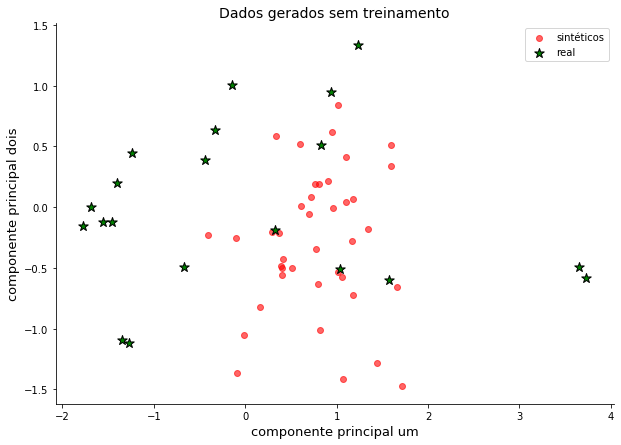

In [12]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0]*2, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.6)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [13]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [14]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [16]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [17]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    precision = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, precision

In [98]:
noise_input = 50
#Gerador
optimizerG = SGD(lr=0.00011, momentum=0.92, decay=0.0001/2000)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/2000)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_26 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_27 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [99]:
ep = 2000
g_loss, d_loss, precision = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/2000] [Discriminator::d_loss: 0.676159],[Generator::loss: 0.786752], 2.653577[sec]
epoch:[2/2000] [Discriminator::d_loss: 0.682361],[Generator::loss: 0.706655], 0.010627[sec]
epoch:[3/2000] [Discriminator::d_loss: 0.672698],[Generator::loss: 0.762425], 0.010785[sec]
epoch:[4/2000] [Discriminator::d_loss: 0.660834],[Generator::loss: 0.815234], 0.010992[sec]
epoch:[5/2000] [Discriminator::d_loss: 0.664068],[Generator::loss: 0.792416], 0.011019[sec]
epoch:[6/2000] [Discriminator::d_loss: 0.664858],[Generator::loss: 0.785724], 0.010834[sec]
epoch:[7/2000] [Discriminator::d_loss: 0.670844],[Generator::loss: 0.640482], 0.010622[sec]
epoch:[8/2000] [Discriminator::d_loss: 0.666285],[Generator::loss: 0.734102], 0.010646[sec]
epoch:[9/2000] [Discriminator::d_loss: 0.663317],[Generator::loss: 0.850896], 0.010789[sec]
epoch:[10/2000] [Discriminator::d_loss: 0.663741],[Generator::loss: 0.861123], 0.010786[sec]
epoch:[11/2000] [Discriminator::d_loss: 0.648675],[Generator::loss: 0.664235], 

epoch:[92/2000] [Discriminator::d_loss: 0.621092],[Generator::loss: 0.802386], 0.011684[sec]
epoch:[93/2000] [Discriminator::d_loss: 0.657135],[Generator::loss: 0.715767], 0.011989[sec]
epoch:[94/2000] [Discriminator::d_loss: 0.648407],[Generator::loss: 0.734340], 0.014485[sec]
epoch:[95/2000] [Discriminator::d_loss: 0.592605],[Generator::loss: 0.835990], 0.011098[sec]
epoch:[96/2000] [Discriminator::d_loss: 0.662396],[Generator::loss: 0.812001], 0.010623[sec]
epoch:[97/2000] [Discriminator::d_loss: 0.602306],[Generator::loss: 0.746293], 0.010681[sec]
epoch:[98/2000] [Discriminator::d_loss: 0.657332],[Generator::loss: 0.764375], 0.010517[sec]
epoch:[99/2000] [Discriminator::d_loss: 0.641404],[Generator::loss: 0.830021], 0.010532[sec]
epoch:[100/2000] [Discriminator::d_loss: 0.675992],[Generator::loss: 0.712825], 0.010607[sec]
epoch:[101/2000] [Discriminator::d_loss: 0.627770],[Generator::loss: 0.755790], 0.010756[sec]
epoch:[102/2000] [Discriminator::d_loss: 0.651311],[Generator::loss:

epoch:[181/2000] [Discriminator::d_loss: 0.613196],[Generator::loss: 0.798417], 0.011862[sec]
epoch:[182/2000] [Discriminator::d_loss: 0.668698],[Generator::loss: 0.748601], 0.017146[sec]
epoch:[183/2000] [Discriminator::d_loss: 0.648860],[Generator::loss: 0.851183], 0.010998[sec]
epoch:[184/2000] [Discriminator::d_loss: 0.577926],[Generator::loss: 0.838680], 0.010817[sec]
epoch:[185/2000] [Discriminator::d_loss: 0.612078],[Generator::loss: 0.779181], 0.010803[sec]
epoch:[186/2000] [Discriminator::d_loss: 0.615745],[Generator::loss: 0.790908], 0.010524[sec]
epoch:[187/2000] [Discriminator::d_loss: 0.590214],[Generator::loss: 0.843296], 0.010820[sec]
epoch:[188/2000] [Discriminator::d_loss: 0.607843],[Generator::loss: 0.761375], 0.010835[sec]
epoch:[189/2000] [Discriminator::d_loss: 0.624715],[Generator::loss: 0.754343], 0.010602[sec]
epoch:[190/2000] [Discriminator::d_loss: 0.583459],[Generator::loss: 0.830454], 0.010504[sec]
epoch:[191/2000] [Discriminator::d_loss: 0.644024],[Generato

epoch:[271/2000] [Discriminator::d_loss: 0.604735],[Generator::loss: 0.851805], 0.011198[sec]
epoch:[272/2000] [Discriminator::d_loss: 0.572762],[Generator::loss: 0.820114], 0.014403[sec]
epoch:[273/2000] [Discriminator::d_loss: 0.606460],[Generator::loss: 0.836051], 0.010980[sec]
epoch:[274/2000] [Discriminator::d_loss: 0.581978],[Generator::loss: 0.802368], 0.010972[sec]
epoch:[275/2000] [Discriminator::d_loss: 0.590924],[Generator::loss: 0.836091], 0.010977[sec]
epoch:[276/2000] [Discriminator::d_loss: 0.582558],[Generator::loss: 0.810508], 0.010850[sec]
epoch:[277/2000] [Discriminator::d_loss: 0.622433],[Generator::loss: 0.722724], 0.010556[sec]
epoch:[278/2000] [Discriminator::d_loss: 0.581864],[Generator::loss: 0.892461], 0.010803[sec]
epoch:[279/2000] [Discriminator::d_loss: 0.644249],[Generator::loss: 0.864620], 0.010719[sec]
epoch:[280/2000] [Discriminator::d_loss: 0.582725],[Generator::loss: 0.902115], 0.010627[sec]
epoch:[281/2000] [Discriminator::d_loss: 0.574143],[Generato

epoch:[365/2000] [Discriminator::d_loss: 0.558340],[Generator::loss: 0.872031], 0.012597[sec]
epoch:[366/2000] [Discriminator::d_loss: 0.572569],[Generator::loss: 0.827279], 0.012272[sec]
epoch:[367/2000] [Discriminator::d_loss: 0.576137],[Generator::loss: 0.862928], 0.011163[sec]
epoch:[368/2000] [Discriminator::d_loss: 0.607093],[Generator::loss: 0.899296], 0.010712[sec]
epoch:[369/2000] [Discriminator::d_loss: 0.571251],[Generator::loss: 0.842282], 0.010834[sec]
epoch:[370/2000] [Discriminator::d_loss: 0.565832],[Generator::loss: 0.857356], 0.010755[sec]
epoch:[371/2000] [Discriminator::d_loss: 0.549204],[Generator::loss: 0.868620], 0.010666[sec]
epoch:[372/2000] [Discriminator::d_loss: 0.578459],[Generator::loss: 0.804970], 0.010651[sec]
epoch:[373/2000] [Discriminator::d_loss: 0.595667],[Generator::loss: 0.789366], 0.010578[sec]
epoch:[374/2000] [Discriminator::d_loss: 0.604832],[Generator::loss: 0.783196], 0.010732[sec]
epoch:[375/2000] [Discriminator::d_loss: 0.574067],[Generato

epoch:[460/2000] [Discriminator::d_loss: 0.599971],[Generator::loss: 0.846064], 0.016923[sec]
epoch:[461/2000] [Discriminator::d_loss: 0.583584],[Generator::loss: 0.808654], 0.012453[sec]
epoch:[462/2000] [Discriminator::d_loss: 0.560567],[Generator::loss: 0.984526], 0.011091[sec]
epoch:[463/2000] [Discriminator::d_loss: 0.590554],[Generator::loss: 0.849492], 0.010771[sec]
epoch:[464/2000] [Discriminator::d_loss: 0.536795],[Generator::loss: 0.955879], 0.010977[sec]
epoch:[465/2000] [Discriminator::d_loss: 0.574625],[Generator::loss: 0.965763], 0.010829[sec]
epoch:[466/2000] [Discriminator::d_loss: 0.603815],[Generator::loss: 0.890048], 0.010787[sec]
epoch:[467/2000] [Discriminator::d_loss: 0.560732],[Generator::loss: 0.840218], 0.010562[sec]
epoch:[468/2000] [Discriminator::d_loss: 0.592028],[Generator::loss: 0.877517], 0.010628[sec]
epoch:[469/2000] [Discriminator::d_loss: 0.562946],[Generator::loss: 0.829329], 0.010763[sec]
epoch:[470/2000] [Discriminator::d_loss: 0.547531],[Generato

epoch:[555/2000] [Discriminator::d_loss: 0.590160],[Generator::loss: 0.848431], 0.012999[sec]
epoch:[556/2000] [Discriminator::d_loss: 0.563502],[Generator::loss: 0.899046], 0.011978[sec]
epoch:[557/2000] [Discriminator::d_loss: 0.548568],[Generator::loss: 0.967371], 0.011136[sec]
epoch:[558/2000] [Discriminator::d_loss: 0.562867],[Generator::loss: 0.892393], 0.010630[sec]
epoch:[559/2000] [Discriminator::d_loss: 0.656831],[Generator::loss: 0.907679], 0.010531[sec]
epoch:[560/2000] [Discriminator::d_loss: 0.575146],[Generator::loss: 0.979171], 0.010664[sec]
epoch:[561/2000] [Discriminator::d_loss: 0.601915],[Generator::loss: 0.908756], 0.010737[sec]
epoch:[562/2000] [Discriminator::d_loss: 0.545448],[Generator::loss: 0.829052], 0.010911[sec]
epoch:[563/2000] [Discriminator::d_loss: 0.598944],[Generator::loss: 0.851025], 0.010729[sec]
epoch:[564/2000] [Discriminator::d_loss: 0.589742],[Generator::loss: 0.894356], 0.010643[sec]
epoch:[565/2000] [Discriminator::d_loss: 0.549378],[Generato

epoch:[650/2000] [Discriminator::d_loss: 0.600540],[Generator::loss: 0.891765], 0.012225[sec]
epoch:[651/2000] [Discriminator::d_loss: 0.578289],[Generator::loss: 0.948712], 0.012662[sec]
epoch:[652/2000] [Discriminator::d_loss: 0.565535],[Generator::loss: 0.941952], 0.010962[sec]
epoch:[653/2000] [Discriminator::d_loss: 0.531915],[Generator::loss: 0.886246], 0.010829[sec]
epoch:[654/2000] [Discriminator::d_loss: 0.574971],[Generator::loss: 0.836014], 0.010639[sec]
epoch:[655/2000] [Discriminator::d_loss: 0.529861],[Generator::loss: 0.880608], 0.010478[sec]
epoch:[656/2000] [Discriminator::d_loss: 0.581111],[Generator::loss: 0.858944], 0.010694[sec]
epoch:[657/2000] [Discriminator::d_loss: 0.594066],[Generator::loss: 0.844839], 0.010761[sec]
epoch:[658/2000] [Discriminator::d_loss: 0.561072],[Generator::loss: 0.899305], 0.011037[sec]
epoch:[659/2000] [Discriminator::d_loss: 0.543929],[Generator::loss: 0.852920], 0.010567[sec]
epoch:[660/2000] [Discriminator::d_loss: 0.547203],[Generato

epoch:[745/2000] [Discriminator::d_loss: 0.602246],[Generator::loss: 0.812518], 0.012656[sec]
epoch:[746/2000] [Discriminator::d_loss: 0.595533],[Generator::loss: 0.912921], 0.012579[sec]
epoch:[747/2000] [Discriminator::d_loss: 0.579133],[Generator::loss: 0.900696], 0.011227[sec]
epoch:[748/2000] [Discriminator::d_loss: 0.571471],[Generator::loss: 0.930723], 0.010781[sec]
epoch:[749/2000] [Discriminator::d_loss: 0.564539],[Generator::loss: 0.827324], 0.010972[sec]
epoch:[750/2000] [Discriminator::d_loss: 0.623088],[Generator::loss: 0.898668], 0.010583[sec]
epoch:[751/2000] [Discriminator::d_loss: 0.593594],[Generator::loss: 0.864126], 0.010399[sec]
epoch:[752/2000] [Discriminator::d_loss: 0.589261],[Generator::loss: 0.979529], 0.010617[sec]
epoch:[753/2000] [Discriminator::d_loss: 0.601479],[Generator::loss: 0.898269], 0.010658[sec]
epoch:[754/2000] [Discriminator::d_loss: 0.575395],[Generator::loss: 0.980968], 0.010836[sec]
epoch:[755/2000] [Discriminator::d_loss: 0.624270],[Generato

epoch:[837/2000] [Discriminator::d_loss: 0.570379],[Generator::loss: 0.914289], 0.011228[sec]
epoch:[838/2000] [Discriminator::d_loss: 0.585701],[Generator::loss: 0.881736], 0.018393[sec]
epoch:[839/2000] [Discriminator::d_loss: 0.602393],[Generator::loss: 0.900638], 0.010748[sec]
epoch:[840/2000] [Discriminator::d_loss: 0.603163],[Generator::loss: 0.911627], 0.010923[sec]
epoch:[841/2000] [Discriminator::d_loss: 0.610621],[Generator::loss: 0.917466], 0.010792[sec]
epoch:[842/2000] [Discriminator::d_loss: 0.607113],[Generator::loss: 0.946015], 0.010869[sec]
epoch:[843/2000] [Discriminator::d_loss: 0.594090],[Generator::loss: 0.743641], 0.010457[sec]
epoch:[844/2000] [Discriminator::d_loss: 0.648791],[Generator::loss: 0.848399], 0.010560[sec]
epoch:[845/2000] [Discriminator::d_loss: 0.556616],[Generator::loss: 0.934636], 0.010526[sec]
epoch:[846/2000] [Discriminator::d_loss: 0.572986],[Generator::loss: 0.841138], 0.010761[sec]
epoch:[847/2000] [Discriminator::d_loss: 0.589001],[Generato

epoch:[929/2000] [Discriminator::d_loss: 0.629124],[Generator::loss: 0.836259], 0.015636[sec]
epoch:[930/2000] [Discriminator::d_loss: 0.579830],[Generator::loss: 0.907093], 0.013374[sec]
epoch:[931/2000] [Discriminator::d_loss: 0.659358],[Generator::loss: 0.849359], 0.011172[sec]
epoch:[932/2000] [Discriminator::d_loss: 0.613064],[Generator::loss: 0.727753], 0.011001[sec]
epoch:[933/2000] [Discriminator::d_loss: 0.575964],[Generator::loss: 0.750711], 0.010707[sec]
epoch:[934/2000] [Discriminator::d_loss: 0.619146],[Generator::loss: 0.836360], 0.010815[sec]
epoch:[935/2000] [Discriminator::d_loss: 0.652988],[Generator::loss: 0.733485], 0.010851[sec]
epoch:[936/2000] [Discriminator::d_loss: 0.598819],[Generator::loss: 0.853313], 0.010883[sec]
epoch:[937/2000] [Discriminator::d_loss: 0.705998],[Generator::loss: 0.723603], 0.010627[sec]
epoch:[938/2000] [Discriminator::d_loss: 0.634023],[Generator::loss: 0.803885], 0.010770[sec]
epoch:[939/2000] [Discriminator::d_loss: 0.604390],[Generato

epoch:[1019/2000] [Discriminator::d_loss: 0.592584],[Generator::loss: 0.949701], 0.011433[sec]
epoch:[1020/2000] [Discriminator::d_loss: 0.634358],[Generator::loss: 0.730862], 0.013731[sec]
epoch:[1021/2000] [Discriminator::d_loss: 0.620327],[Generator::loss: 0.782909], 0.010958[sec]
epoch:[1022/2000] [Discriminator::d_loss: 0.614802],[Generator::loss: 0.662937], 0.010849[sec]
epoch:[1023/2000] [Discriminator::d_loss: 0.618494],[Generator::loss: 0.829657], 0.011065[sec]
epoch:[1024/2000] [Discriminator::d_loss: 0.675491],[Generator::loss: 0.883435], 0.010875[sec]
epoch:[1025/2000] [Discriminator::d_loss: 0.680919],[Generator::loss: 0.864799], 0.010428[sec]
epoch:[1026/2000] [Discriminator::d_loss: 0.601886],[Generator::loss: 0.864217], 0.010976[sec]
epoch:[1027/2000] [Discriminator::d_loss: 0.577703],[Generator::loss: 0.894369], 0.010549[sec]
epoch:[1028/2000] [Discriminator::d_loss: 0.625256],[Generator::loss: 0.903393], 0.010618[sec]
epoch:[1029/2000] [Discriminator::d_loss: 0.603958

epoch:[1110/2000] [Discriminator::d_loss: 0.654042],[Generator::loss: 0.858849], 0.017155[sec]
epoch:[1111/2000] [Discriminator::d_loss: 0.653197],[Generator::loss: 0.784125], 0.012656[sec]
epoch:[1112/2000] [Discriminator::d_loss: 0.716772],[Generator::loss: 0.777354], 0.010968[sec]
epoch:[1113/2000] [Discriminator::d_loss: 0.627998],[Generator::loss: 0.858110], 0.010948[sec]
epoch:[1114/2000] [Discriminator::d_loss: 0.597174],[Generator::loss: 0.876161], 0.010855[sec]
epoch:[1115/2000] [Discriminator::d_loss: 0.637955],[Generator::loss: 0.794729], 0.010740[sec]
epoch:[1116/2000] [Discriminator::d_loss: 0.655538],[Generator::loss: 0.813403], 0.010595[sec]
epoch:[1117/2000] [Discriminator::d_loss: 0.664314],[Generator::loss: 0.847085], 0.010766[sec]
epoch:[1118/2000] [Discriminator::d_loss: 0.652147],[Generator::loss: 0.814323], 0.010619[sec]
epoch:[1119/2000] [Discriminator::d_loss: 0.672340],[Generator::loss: 0.798913], 0.010739[sec]
epoch:[1120/2000] [Discriminator::d_loss: 0.650824

epoch:[1204/2000] [Discriminator::d_loss: 0.669026],[Generator::loss: 0.880118], 0.018567[sec]
epoch:[1205/2000] [Discriminator::d_loss: 0.657222],[Generator::loss: 0.758676], 0.011242[sec]
epoch:[1206/2000] [Discriminator::d_loss: 0.631960],[Generator::loss: 0.842360], 0.011077[sec]
epoch:[1207/2000] [Discriminator::d_loss: 0.735225],[Generator::loss: 0.840191], 0.010770[sec]
epoch:[1208/2000] [Discriminator::d_loss: 0.670974],[Generator::loss: 0.831567], 0.010890[sec]
epoch:[1209/2000] [Discriminator::d_loss: 0.666527],[Generator::loss: 0.768160], 0.010798[sec]
epoch:[1210/2000] [Discriminator::d_loss: 0.649725],[Generator::loss: 0.729050], 0.010703[sec]
epoch:[1211/2000] [Discriminator::d_loss: 0.681481],[Generator::loss: 0.772374], 0.010958[sec]
epoch:[1212/2000] [Discriminator::d_loss: 0.654120],[Generator::loss: 0.755368], 0.010513[sec]
epoch:[1213/2000] [Discriminator::d_loss: 0.640614],[Generator::loss: 0.708965], 0.010682[sec]
epoch:[1214/2000] [Discriminator::d_loss: 0.689552

epoch:[1298/2000] [Discriminator::d_loss: 0.709738],[Generator::loss: 0.698613], 0.012093[sec]
epoch:[1299/2000] [Discriminator::d_loss: 0.723580],[Generator::loss: 0.801006], 0.017435[sec]
epoch:[1300/2000] [Discriminator::d_loss: 0.682814],[Generator::loss: 0.839436], 0.010732[sec]
epoch:[1301/2000] [Discriminator::d_loss: 0.653191],[Generator::loss: 0.746690], 0.011181[sec]
epoch:[1302/2000] [Discriminator::d_loss: 0.702170],[Generator::loss: 0.750591], 0.010947[sec]
epoch:[1303/2000] [Discriminator::d_loss: 0.678018],[Generator::loss: 0.801664], 0.012294[sec]
epoch:[1304/2000] [Discriminator::d_loss: 0.637439],[Generator::loss: 0.856386], 0.010713[sec]
epoch:[1305/2000] [Discriminator::d_loss: 0.677513],[Generator::loss: 0.789389], 0.010944[sec]
epoch:[1306/2000] [Discriminator::d_loss: 0.691667],[Generator::loss: 0.718346], 0.010817[sec]
epoch:[1307/2000] [Discriminator::d_loss: 0.684277],[Generator::loss: 0.762919], 0.010925[sec]
epoch:[1308/2000] [Discriminator::d_loss: 0.661055

epoch:[1388/2000] [Discriminator::d_loss: 0.683293],[Generator::loss: 0.768987], 0.011733[sec]
epoch:[1389/2000] [Discriminator::d_loss: 0.614715],[Generator::loss: 0.832857], 0.013817[sec]
epoch:[1390/2000] [Discriminator::d_loss: 0.678533],[Generator::loss: 0.789805], 0.010957[sec]
epoch:[1391/2000] [Discriminator::d_loss: 0.697873],[Generator::loss: 0.757709], 0.011573[sec]
epoch:[1392/2000] [Discriminator::d_loss: 0.668716],[Generator::loss: 0.752887], 0.011029[sec]
epoch:[1393/2000] [Discriminator::d_loss: 0.667050],[Generator::loss: 0.689427], 0.010643[sec]
epoch:[1394/2000] [Discriminator::d_loss: 0.623883],[Generator::loss: 0.736972], 0.010739[sec]
epoch:[1395/2000] [Discriminator::d_loss: 0.693377],[Generator::loss: 0.781742], 0.010630[sec]
epoch:[1396/2000] [Discriminator::d_loss: 0.646995],[Generator::loss: 0.790968], 0.010588[sec]
epoch:[1397/2000] [Discriminator::d_loss: 0.702802],[Generator::loss: 0.785429], 0.010958[sec]
epoch:[1398/2000] [Discriminator::d_loss: 0.687645

epoch:[1478/2000] [Discriminator::d_loss: 0.680816],[Generator::loss: 0.817083], 0.011453[sec]
epoch:[1479/2000] [Discriminator::d_loss: 0.684107],[Generator::loss: 0.729501], 0.013581[sec]
epoch:[1480/2000] [Discriminator::d_loss: 0.676800],[Generator::loss: 0.714604], 0.011508[sec]
epoch:[1481/2000] [Discriminator::d_loss: 0.671621],[Generator::loss: 0.803084], 0.010969[sec]
epoch:[1482/2000] [Discriminator::d_loss: 0.689478],[Generator::loss: 0.811327], 0.010861[sec]
epoch:[1483/2000] [Discriminator::d_loss: 0.682385],[Generator::loss: 0.782617], 0.010886[sec]
epoch:[1484/2000] [Discriminator::d_loss: 0.718914],[Generator::loss: 0.760120], 0.010859[sec]
epoch:[1485/2000] [Discriminator::d_loss: 0.664176],[Generator::loss: 0.698362], 0.010723[sec]
epoch:[1486/2000] [Discriminator::d_loss: 0.637716],[Generator::loss: 0.781364], 0.010603[sec]
epoch:[1487/2000] [Discriminator::d_loss: 0.665484],[Generator::loss: 0.775467], 0.010783[sec]
epoch:[1488/2000] [Discriminator::d_loss: 0.683311

epoch:[1569/2000] [Discriminator::d_loss: 0.677350],[Generator::loss: 0.794975], 0.016175[sec]
epoch:[1570/2000] [Discriminator::d_loss: 0.633198],[Generator::loss: 0.733189], 0.012449[sec]
epoch:[1571/2000] [Discriminator::d_loss: 0.691976],[Generator::loss: 0.769090], 0.010949[sec]
epoch:[1572/2000] [Discriminator::d_loss: 0.706615],[Generator::loss: 0.776566], 0.011044[sec]
epoch:[1573/2000] [Discriminator::d_loss: 0.675192],[Generator::loss: 0.785046], 0.010745[sec]
epoch:[1574/2000] [Discriminator::d_loss: 0.643933],[Generator::loss: 0.797336], 0.010731[sec]
epoch:[1575/2000] [Discriminator::d_loss: 0.628975],[Generator::loss: 0.764576], 0.010650[sec]
epoch:[1576/2000] [Discriminator::d_loss: 0.641784],[Generator::loss: 0.865467], 0.010559[sec]
epoch:[1577/2000] [Discriminator::d_loss: 0.685830],[Generator::loss: 0.685977], 0.010727[sec]
epoch:[1578/2000] [Discriminator::d_loss: 0.676803],[Generator::loss: 0.828243], 0.010777[sec]
epoch:[1579/2000] [Discriminator::d_loss: 0.703123

epoch:[1664/2000] [Discriminator::d_loss: 0.632720],[Generator::loss: 0.774962], 0.014035[sec]
epoch:[1665/2000] [Discriminator::d_loss: 0.689681],[Generator::loss: 0.752488], 0.012164[sec]
epoch:[1666/2000] [Discriminator::d_loss: 0.677781],[Generator::loss: 0.743959], 0.010956[sec]
epoch:[1667/2000] [Discriminator::d_loss: 0.680465],[Generator::loss: 0.838676], 0.010758[sec]
epoch:[1668/2000] [Discriminator::d_loss: 0.656368],[Generator::loss: 0.807120], 0.011206[sec]
epoch:[1669/2000] [Discriminator::d_loss: 0.655761],[Generator::loss: 0.729996], 0.010766[sec]
epoch:[1670/2000] [Discriminator::d_loss: 0.695885],[Generator::loss: 0.784032], 0.010505[sec]
epoch:[1671/2000] [Discriminator::d_loss: 0.732776],[Generator::loss: 0.754406], 0.010838[sec]
epoch:[1672/2000] [Discriminator::d_loss: 0.700531],[Generator::loss: 0.737152], 0.010804[sec]
epoch:[1673/2000] [Discriminator::d_loss: 0.676217],[Generator::loss: 0.733336], 0.010771[sec]
epoch:[1674/2000] [Discriminator::d_loss: 0.682243

epoch:[1758/2000] [Discriminator::d_loss: 0.640956],[Generator::loss: 0.702338], 0.011855[sec]
epoch:[1759/2000] [Discriminator::d_loss: 0.655039],[Generator::loss: 0.765371], 0.017123[sec]
epoch:[1760/2000] [Discriminator::d_loss: 0.691890],[Generator::loss: 0.805190], 0.010889[sec]
epoch:[1761/2000] [Discriminator::d_loss: 0.664182],[Generator::loss: 0.793403], 0.012170[sec]
epoch:[1762/2000] [Discriminator::d_loss: 0.664381],[Generator::loss: 0.690645], 0.010898[sec]
epoch:[1763/2000] [Discriminator::d_loss: 0.705354],[Generator::loss: 0.770354], 0.010836[sec]
epoch:[1764/2000] [Discriminator::d_loss: 0.697365],[Generator::loss: 0.757738], 0.010595[sec]
epoch:[1765/2000] [Discriminator::d_loss: 0.673930],[Generator::loss: 0.718983], 0.010879[sec]
epoch:[1766/2000] [Discriminator::d_loss: 0.724647],[Generator::loss: 0.727399], 0.010739[sec]
epoch:[1767/2000] [Discriminator::d_loss: 0.706620],[Generator::loss: 0.737754], 0.010641[sec]
epoch:[1768/2000] [Discriminator::d_loss: 0.699490

epoch:[1850/2000] [Discriminator::d_loss: 0.707771],[Generator::loss: 0.767962], 0.017186[sec]
epoch:[1851/2000] [Discriminator::d_loss: 0.704925],[Generator::loss: 0.760049], 0.014472[sec]
epoch:[1852/2000] [Discriminator::d_loss: 0.691344],[Generator::loss: 0.762877], 0.011306[sec]
epoch:[1853/2000] [Discriminator::d_loss: 0.698292],[Generator::loss: 0.748293], 0.011060[sec]
epoch:[1854/2000] [Discriminator::d_loss: 0.691758],[Generator::loss: 0.745273], 0.011083[sec]
epoch:[1855/2000] [Discriminator::d_loss: 0.680243],[Generator::loss: 0.755534], 0.011146[sec]
epoch:[1856/2000] [Discriminator::d_loss: 0.674026],[Generator::loss: 0.717856], 0.010970[sec]
epoch:[1857/2000] [Discriminator::d_loss: 0.672547],[Generator::loss: 0.804324], 0.010977[sec]
epoch:[1858/2000] [Discriminator::d_loss: 0.675892],[Generator::loss: 0.752579], 0.011024[sec]
epoch:[1859/2000] [Discriminator::d_loss: 0.705684],[Generator::loss: 0.774754], 0.010968[sec]
epoch:[1860/2000] [Discriminator::d_loss: 0.704584

epoch:[1940/2000] [Discriminator::d_loss: 0.678469],[Generator::loss: 0.733924], 0.012642[sec]
epoch:[1941/2000] [Discriminator::d_loss: 0.692589],[Generator::loss: 0.713320], 0.013619[sec]
epoch:[1942/2000] [Discriminator::d_loss: 0.682444],[Generator::loss: 0.704773], 0.011185[sec]
epoch:[1943/2000] [Discriminator::d_loss: 0.705595],[Generator::loss: 0.745919], 0.011130[sec]
epoch:[1944/2000] [Discriminator::d_loss: 0.669236],[Generator::loss: 0.725750], 0.011086[sec]
epoch:[1945/2000] [Discriminator::d_loss: 0.674936],[Generator::loss: 0.722555], 0.010903[sec]
epoch:[1946/2000] [Discriminator::d_loss: 0.700874],[Generator::loss: 0.728388], 0.010762[sec]
epoch:[1947/2000] [Discriminator::d_loss: 0.678940],[Generator::loss: 0.705663], 0.010799[sec]
epoch:[1948/2000] [Discriminator::d_loss: 0.696448],[Generator::loss: 0.675350], 0.010956[sec]
epoch:[1949/2000] [Discriminator::d_loss: 0.687170],[Generator::loss: 0.737232], 0.011195[sec]
epoch:[1950/2000] [Discriminator::d_loss: 0.681595

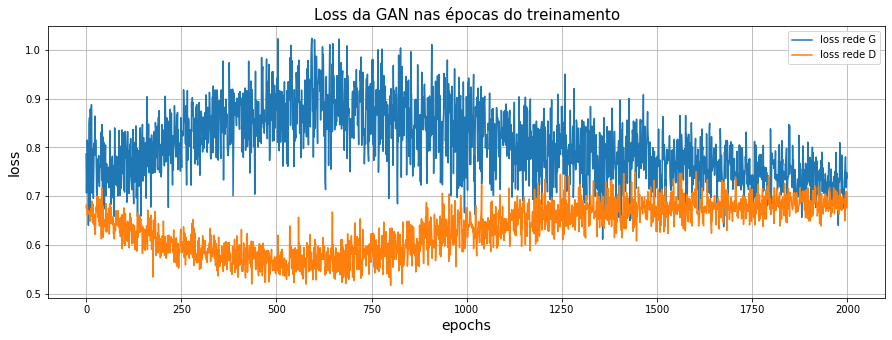

In [100]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

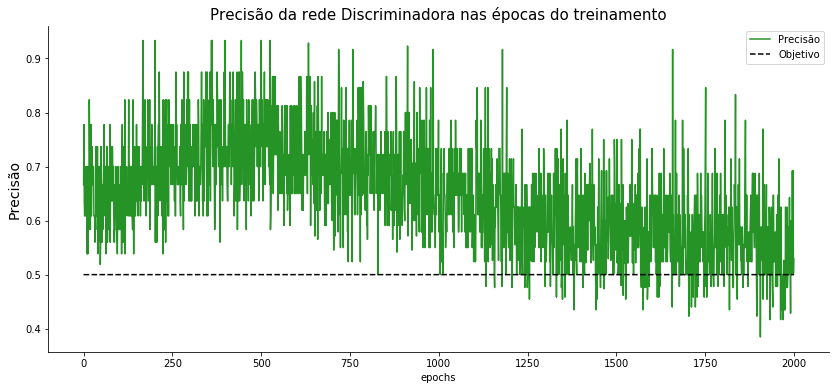

In [101]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

(20, 2) (300, 2)


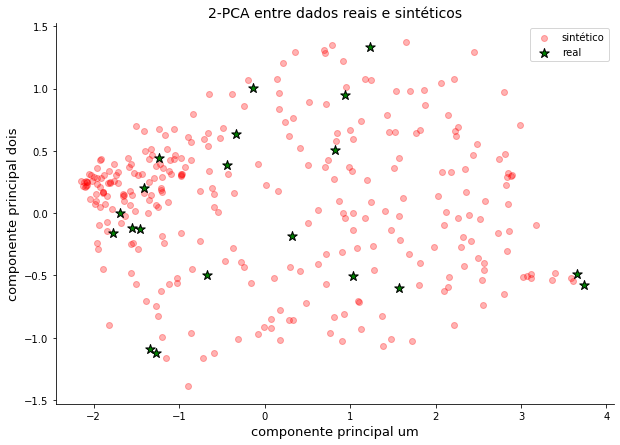

In [102]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(300, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [103]:
score = []
for i in range(5000):
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    score.append(precision_score(y_test, y_predict))

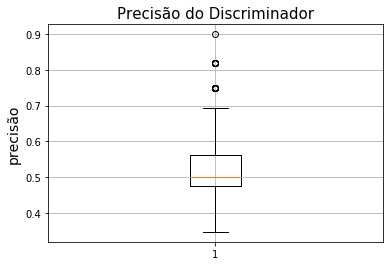

In [104]:
plt.title("Precisão do Discriminador", fontsize=15)
plt.ylabel("precisão", fontsize=14)
plt.grid("y")
plt.boxplot(score);

In [105]:
np.mean(score), np.std(score), np.median(score)

(0.5168746216093101, 0.06690011996294079, 0.5)

In [106]:
X_train.shape

(20, 9)

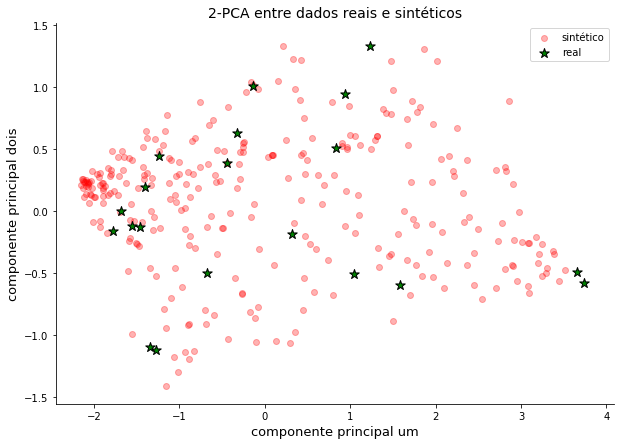

In [114]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train.iloc[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [115]:
X_nov.shape

(314, 9)

### One-class classification with SVM

In [120]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.01, gamma=.1).fit(X_nov)

print("score no treinamento: ", np.mean(clf.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train.iloc[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train.iloc[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train)==1))

score no treinamento:  0.9745222929936306
score nos genes de referência de treinamento:  0.8571428571428571
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.85


In [121]:
#gan.save("./data/best_gan.h5")

In [122]:
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964250,-1.031994,-0.934337,-0.939543,-0.937269
aaeB,-1.009480,-1.042995,-1.041304,-1.034891,-1.060889,-1.063096,-1.039629,-0.965042,-0.989310
aaeR,-1.006916,-0.996388,-1.082667,-0.987112,-1.078005,-1.014922,-1.058494,-0.940447,0.509951
aaeX,-0.943096,-0.955260,-0.950883,-0.910106,0.425601,-1.000392,-1.010278,-0.964826,0.441659
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996782,-0.974946,-0.973578,-0.897515,-0.892211


In [123]:
predict_cand = clf.predict(datos)

In [124]:
cand = datos[predict_cand == 1]
no_cand = datos[predict_cand == -1]
cand.shape, no_cand.shape

((873, 9), (3312, 9))

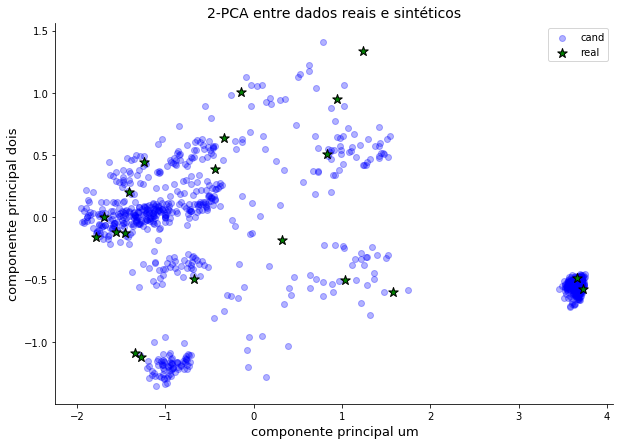

In [125]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand[:,0], X_cand[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="green", label="sintéticos",alpha=1, edgecolors="black")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [126]:
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

redução do  79.13978494623656 % no processo de escolha de candidatos


In [127]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [128]:
datos.loc[cand.loc[rg_moose].dropna().index]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242


In [129]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242


In [130]:
obj_edi = open("data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [131]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
prfB,1.041426,1.043074,-0.282184,1.046805,1.046628,0.958977,0.845067,0.715257,0.881996
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060
ychF,0.969259,1.012508,-0.312707,0.978325,-0.502400,0.922555,0.751064,0.574691,0.696657


In [132]:
class one_class_gan:
    
    def __init__(self, X_train, noise_input, epochs):
        self.X_train = X_train
        self.noise_input = noise_input
        self.epochs = epochs
        #building gan
        optG = SGD(lr=0.00011, momentum=0.92, decay=0.0001/self.epochs)
        optD = SGD(lr=0.00021, momentum=0.92, decay=0.0001/self.epochs)
        self.G = self.generator(optG)
        self.D = self.discriminator(optD)
        self.gan = self.build_gan(self.G, self.D, optG) 
        
    def generator(self, opt):
        model = Sequential()
        model.add(Dense(30, input_shape=(self.noise_input,)))
        model.add(Dense(30))
        model.add(Dense(X_train.shape[1], activation="tanh"))
        model.compile(loss="binary_crossentropy",
                      optimizer=opt)
        return model
    
    def discriminator(self, opt):
        model = Sequential()
        model.add(Dense(32, input_shape=(self.X_train.shape[1],)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)
        return model
    
    def build_gan(self, G, D, opt):
        model = Sequential()
        model.add(G)
        D.trainable = False
        model.add(D)
        model.compile(loss="binary_crossentropy", optimizer=opt)
        return model
        
    def get_batches(self, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(self.X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > self.X_train.shape[0]:
                lim_s = self.X_train.shape[0]
            batches.append(self.X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
        return batches

    def train(self, epochs, batch_size):       
        g_loss = []
        d_loss = []
        precision = []
        for epoch in range(epochs):
            batches = self.get_batches(batch_size)
            count_b = 0
            t_i = time()
            d_bacth_loss = []
            g_bacth_loss = []
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_data = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_data))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #misturar os dados
                #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
                #treino do discriminador
                d_bacth_loss.append(self.D.train_on_batch(x_combined_batch, y_combined_batch)[0])
                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))
                g_bacth_loss.append(self.gan.train_on_batch(noise, y_mislabled))

            #precision
            X_sint = self.G.predict(np.random.normal(0, 1, (self.X_train.shape[0], self.noise_input)))
            X_comb = np.concatenate((self.X_train, X_sint))
            y_comb = np.concatenate((np.ones((self.X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
            y_predict = self.D.predict_classes(X_comb)
            #f1_lag = f1_score(y_test, y_predict)
            precision.append(precision_score(y_comb, y_predict))
            #fscore.append(f1_lag)
            t_f = time()
            t = t_f - t_i
            t_i = time()
            #d_loss.append(np.mean(np.array(d_bacth_loss)))
            #g_loss.append(np.mean(np.array(g_bacth_loss)))
            d_loss.append(d_bacth_loss[-1])
            g_loss.append(g_bacth_loss[-1])
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                       % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
            #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
            #    break
        return g_loss, d_loss, precision

In [133]:
X_nov.shape

(314, 9)

In [166]:
obj_oc = one_class_gan(X_nov, 50, 500)
gloss, dloss, d_precision  = obj_oc.train(500, batch_size=int(X_nov.shape[0]/2))

epoch:[1/500] [Discriminator::d_loss: 0.759421],[Generator::loss: 0.826194], 5.534810[sec]
epoch:[2/500] [Discriminator::d_loss: 0.762660],[Generator::loss: 0.802057], 0.055430[sec]
epoch:[3/500] [Discriminator::d_loss: 0.745684],[Generator::loss: 0.798280], 0.054434[sec]
epoch:[4/500] [Discriminator::d_loss: 0.753610],[Generator::loss: 0.817597], 0.054370[sec]
epoch:[5/500] [Discriminator::d_loss: 0.757651],[Generator::loss: 0.813304], 0.061594[sec]
epoch:[6/500] [Discriminator::d_loss: 0.777368],[Generator::loss: 0.827345], 0.060167[sec]
epoch:[7/500] [Discriminator::d_loss: 0.743781],[Generator::loss: 0.812528], 0.053969[sec]
epoch:[8/500] [Discriminator::d_loss: 0.745873],[Generator::loss: 0.803824], 0.053336[sec]
epoch:[9/500] [Discriminator::d_loss: 0.758022],[Generator::loss: 0.809985], 0.064577[sec]
epoch:[10/500] [Discriminator::d_loss: 0.754528],[Generator::loss: 0.823700], 0.060146[sec]
epoch:[11/500] [Discriminator::d_loss: 0.744026],[Generator::loss: 0.830964], 0.061677[se

epoch:[93/500] [Discriminator::d_loss: 0.662502],[Generator::loss: 0.780226], 0.061319[sec]
epoch:[94/500] [Discriminator::d_loss: 0.674233],[Generator::loss: 0.752784], 0.054667[sec]
epoch:[95/500] [Discriminator::d_loss: 0.673840],[Generator::loss: 0.770909], 0.053988[sec]
epoch:[96/500] [Discriminator::d_loss: 0.674152],[Generator::loss: 0.752460], 0.053243[sec]
epoch:[97/500] [Discriminator::d_loss: 0.674693],[Generator::loss: 0.746961], 0.060374[sec]
epoch:[98/500] [Discriminator::d_loss: 0.672245],[Generator::loss: 0.774528], 0.053194[sec]
epoch:[99/500] [Discriminator::d_loss: 0.674623],[Generator::loss: 0.764327], 0.052694[sec]
epoch:[100/500] [Discriminator::d_loss: 0.665476],[Generator::loss: 0.752885], 0.053059[sec]
epoch:[101/500] [Discriminator::d_loss: 0.675205],[Generator::loss: 0.769679], 0.060687[sec]
epoch:[102/500] [Discriminator::d_loss: 0.670998],[Generator::loss: 0.779909], 0.053434[sec]
epoch:[103/500] [Discriminator::d_loss: 0.671619],[Generator::loss: 0.756866]

epoch:[185/500] [Discriminator::d_loss: 0.634378],[Generator::loss: 0.747887], 0.067739[sec]
epoch:[186/500] [Discriminator::d_loss: 0.640966],[Generator::loss: 0.754726], 0.057670[sec]
epoch:[187/500] [Discriminator::d_loss: 0.647778],[Generator::loss: 0.754894], 0.054171[sec]
epoch:[188/500] [Discriminator::d_loss: 0.629853],[Generator::loss: 0.751918], 0.053251[sec]
epoch:[189/500] [Discriminator::d_loss: 0.633477],[Generator::loss: 0.751739], 0.063772[sec]
epoch:[190/500] [Discriminator::d_loss: 0.644980],[Generator::loss: 0.776860], 0.063930[sec]
epoch:[191/500] [Discriminator::d_loss: 0.643888],[Generator::loss: 0.763428], 0.057441[sec]
epoch:[192/500] [Discriminator::d_loss: 0.639015],[Generator::loss: 0.765123], 0.058064[sec]
epoch:[193/500] [Discriminator::d_loss: 0.627307],[Generator::loss: 0.758206], 0.064796[sec]
epoch:[194/500] [Discriminator::d_loss: 0.639749],[Generator::loss: 0.772986], 0.068854[sec]
epoch:[195/500] [Discriminator::d_loss: 0.618531],[Generator::loss: 0.

epoch:[276/500] [Discriminator::d_loss: 0.620121],[Generator::loss: 0.760648], 0.063267[sec]
epoch:[277/500] [Discriminator::d_loss: 0.627944],[Generator::loss: 0.768212], 0.053597[sec]
epoch:[278/500] [Discriminator::d_loss: 0.617092],[Generator::loss: 0.780070], 0.052930[sec]
epoch:[279/500] [Discriminator::d_loss: 0.627419],[Generator::loss: 0.769947], 0.053367[sec]
epoch:[280/500] [Discriminator::d_loss: 0.615362],[Generator::loss: 0.790445], 0.059762[sec]
epoch:[281/500] [Discriminator::d_loss: 0.625620],[Generator::loss: 0.791088], 0.054545[sec]
epoch:[282/500] [Discriminator::d_loss: 0.630185],[Generator::loss: 0.772233], 0.053283[sec]
epoch:[283/500] [Discriminator::d_loss: 0.619939],[Generator::loss: 0.776477], 0.054125[sec]
epoch:[284/500] [Discriminator::d_loss: 0.628850],[Generator::loss: 0.773728], 0.059463[sec]
epoch:[285/500] [Discriminator::d_loss: 0.619953],[Generator::loss: 0.754957], 0.054733[sec]
epoch:[286/500] [Discriminator::d_loss: 0.614224],[Generator::loss: 0.

epoch:[368/500] [Discriminator::d_loss: 0.619802],[Generator::loss: 0.771222], 0.061904[sec]
epoch:[369/500] [Discriminator::d_loss: 0.612572],[Generator::loss: 0.809732], 0.053001[sec]
epoch:[370/500] [Discriminator::d_loss: 0.616742],[Generator::loss: 0.772306], 0.054046[sec]
epoch:[371/500] [Discriminator::d_loss: 0.614506],[Generator::loss: 0.785785], 0.052959[sec]
epoch:[372/500] [Discriminator::d_loss: 0.609356],[Generator::loss: 0.761370], 0.063177[sec]
epoch:[373/500] [Discriminator::d_loss: 0.617436],[Generator::loss: 0.770734], 0.055173[sec]
epoch:[374/500] [Discriminator::d_loss: 0.594127],[Generator::loss: 0.770639], 0.054408[sec]
epoch:[375/500] [Discriminator::d_loss: 0.614420],[Generator::loss: 0.782371], 0.054393[sec]
epoch:[376/500] [Discriminator::d_loss: 0.613304],[Generator::loss: 0.797274], 0.058931[sec]
epoch:[377/500] [Discriminator::d_loss: 0.604317],[Generator::loss: 0.762466], 0.053488[sec]
epoch:[378/500] [Discriminator::d_loss: 0.613720],[Generator::loss: 0.

epoch:[460/500] [Discriminator::d_loss: 0.592413],[Generator::loss: 0.783999], 0.062897[sec]
epoch:[461/500] [Discriminator::d_loss: 0.603680],[Generator::loss: 0.774686], 0.054471[sec]
epoch:[462/500] [Discriminator::d_loss: 0.614131],[Generator::loss: 0.786839], 0.053448[sec]
epoch:[463/500] [Discriminator::d_loss: 0.612792],[Generator::loss: 0.787128], 0.053750[sec]
epoch:[464/500] [Discriminator::d_loss: 0.609453],[Generator::loss: 0.796668], 0.062289[sec]
epoch:[465/500] [Discriminator::d_loss: 0.589701],[Generator::loss: 0.791753], 0.054201[sec]
epoch:[466/500] [Discriminator::d_loss: 0.615260],[Generator::loss: 0.796084], 0.052660[sec]
epoch:[467/500] [Discriminator::d_loss: 0.609534],[Generator::loss: 0.785541], 0.052609[sec]
epoch:[468/500] [Discriminator::d_loss: 0.603352],[Generator::loss: 0.778041], 0.057835[sec]
epoch:[469/500] [Discriminator::d_loss: 0.610780],[Generator::loss: 0.782819], 0.056370[sec]
epoch:[470/500] [Discriminator::d_loss: 0.611277],[Generator::loss: 0.

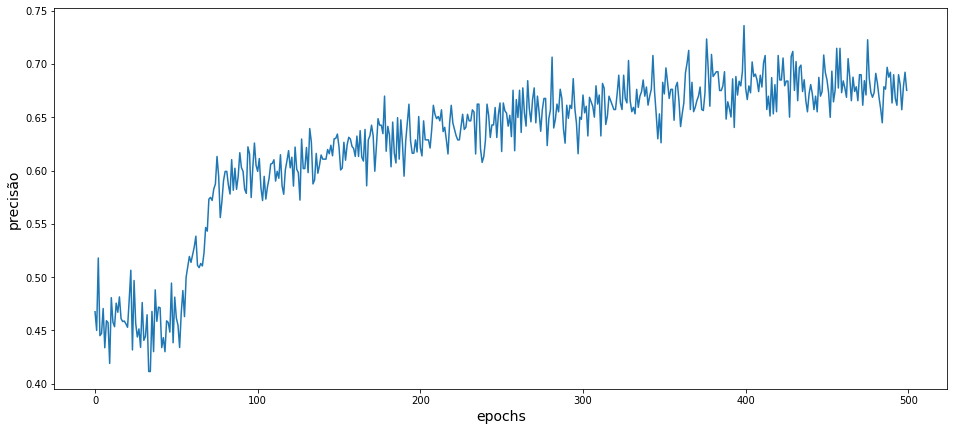

In [167]:
plt.figure(figsize=(16,7))
plt.xlabel("epochs", fontsize=14)
plt.ylabel("precisão", fontsize=14)
plt.plot(range(len(d_precision)), d_precision);

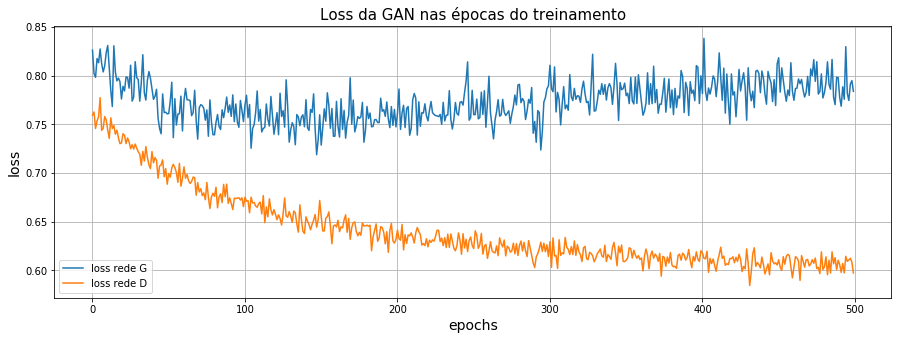

In [168]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(gloss)), gloss, label="loss rede G")
plt.plot(range(len(dloss)), dloss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

In [152]:
np.mean(obj_oc.D.predict_classes(X_train)==1)

0.4